In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from numpy.polynomial.polynomial import polyfit
import seaborn as sns

# get data from my github
df_2020 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2020_NBA_Contracts.csv',index_col = 0)   
df_2021 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2021_NBA_Contracts.csv',index_col = 0)
df_2022 = pd.read_csv(r'https://raw.githubusercontent.com/mkarlthayer/basketball/main/2022_NBA_Contracts.csv',index_col = 0)
print("Imports successful!")

Imports successful!


In [2]:
# combine last 3 years of contract data
df_combined = pd.concat([df_2020, df_2021, df_2022])

In [3]:
# remove any duplicate values
df_combined = df_combined.drop_duplicates()

## EDA ##

In [4]:
df_combined.head()

,Player,Years,Full_Salary,Avg_Salary,Pos,Age,Tm,G,GS,MP,...,X,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP
1,Alec Burks,1,6000000.0,6000000.0,SF-SG,28,TOT,66,19,26.6,...,NaN,2.5,1.2,3.7,0.101,NaN,1.2,-0.7,0.5,1.1
2,Alex Len,1,2258000.0,2258000.0,C,26,TOT,55,12,17.6,...,NaN,1.5,1.0,2.5,0.122,NaN,-0.5,-0.3,-0.7,0.3
3,Anthony Davis,5,189903600.0,37980720.0,PF,26,LAL,62,62,34.4,...,NaN,6.7,4.4,11.1,0.250,NaN,5.4,2.6,8.0,5.4
4,Aron Baynes,2,14350000.0,7175000.0,C,33,PHO,42,28,22.2,...,NaN,1.3,0.8,2.1,0.107,NaN,-0.2,-0.8,-1.0,0.2
5,Austin Rivers,3,9975000.0,3325000.0,SG,27,HOU,68,4,23.4,...,NaN,1.2,1.2,2.4,0.072,NaN,-2.1,-0.4,-2.5,-0.2


In [5]:
#Some players play multiple positions, however this creates far too many different values in the Position column
#I simplified it so each player is represented by only the position they play the most
df_combined = df_combined.replace({'Pos':{'SF-SG': 'SF', 'SF-PF':'SF', 'PF-C':'PF', 'PF-SF':'PF','SG-PG':'SG','PG-SG':'PG','SG-SF':'SG','C-PF':'C'}})

In [6]:
# All data values are within expected ranges
df_combined.describe()

,Years,Full_Salary,Avg_Salary,Age,G,GS,MP,FG,FGA,FG.,...,X,OWS,DWS,WS,WS.48,X.1,OBPM,DBPM,BPM,VORP
count,313.000000,3.130000e+02,3.130000e+02,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,...,0.0,313.000000,313.000000,313.000000,313.000000,0.0,313.000000,313.000000,313.000000,313.000000
mean,2.118211,1.816779e+07,6.268894e+06,27.166134,48.718850,18.322684,19.752077,3.068371,6.552396,0.473038,...,NaN,1.175399,1.084984,2.259105,0.096789,NaN,-0.993610,0.080192,-0.911821,0.429073
std,1.107414,3.337870e+07,7.544011e+06,4.038818,18.627528,20.465293,7.362575,1.684789,3.601184,0.097815,...,NaN,1.385179,0.807297,1.988699,0.068273,NaN,2.836205,1.305876,3.438809,0.810440
min,1.000000,1.445697e+06,1.445697e+06,20.000000,1.000000,0.000000,2.000000,0.000000,0.500000,0.000000,...,NaN,-1.300000,-0.100000,-0.800000,-0.365000,NaN,-16.600000,-5.500000,-22.100000,-1.500000
25%,1.000000,2.389641e+06,1.984359e+06,24.000000,36.000000,2.000000,14.800000,1.900000,3.900000,0.415000,...,NaN,0.200000,0.400000,0.800000,0.062000,NaN,-2.400000,-0.800000,-2.300000,0.000000
50%,2.000000,4.767000e+06,2.700000e+06,27.000000,51.000000,9.000000,19.900000,2.900000,5.900000,0.455000,...,NaN,0.700000,0.900000,1.700000,0.096000,NaN,-0.900000,0.000000,-0.900000,0.200000
75%,3.000000,1.801926e+07,7.500000e+06,30.000000,64.000000,30.000000,24.900000,3.900000,8.200000,0.511000,...,NaN,1.900000,1.500000,3.400000,0.130000,NaN,0.300000,0.900000,0.600000,0.700000
max,5.000000,2.510196e+08,5.020393e+07,40.000000,82.000000,80.000000,37.200000,8.900000,19.300000,1.000000,...,NaN,6.700000,4.400000,11.100000,0.475000,NaN,24.100000,7.000000,31.100000,5.400000


<AxesSubplot:xlabel='Avg_Salary', ylabel='Density'>

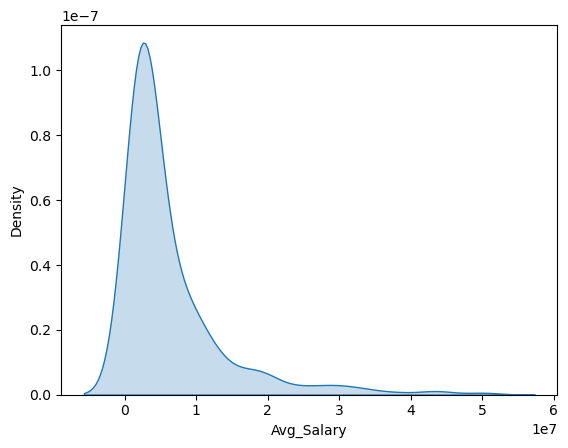

In [7]:
sns.kdeplot(data=df_combined['Avg_Salary'], shade='true')
# salary is right-skewed

In [8]:
#Given how many data points are collected on each player, I used a Pearson R correlation to determine which data points are most correlated to salary
y = df_combined[['Avg_Salary']]
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(df_combined[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.767
Pearsons correlation for TRB: 0.366
Pearsons correlation for AST: 0.566
Pearsons correlation for FGA: 0.716
Pearsons correlation for FG: 0.746
Pearsons correlation for FG.: 0.054
Pearsons correlation for X3P: 0.443
Pearsons correlation for X3PA: 0.440
Pearsons correlation for X2P.: 0.014
Pearsons correlation for STL: 0.411
Pearsons correlation for BLK: 0.161
Pearsons correlation for ORB: 0.123
Pearsons correlation for DRB: 0.450
Pearsons correlation for FT: 0.707
Pearsons correlation for FTA: 0.668
Pearsons correlation for G: 0.302
Pearsons correlation for GS: 0.580
Pearsons correlation for MP: 0.643


In [9]:
y = df_combined[['Avg_Salary']]
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(df_combined[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.722
Pearsons correlation for OWS: 0.651
Pearsons correlation for DWS: 0.474
Pearsons correlation for WS: 0.645
Pearsons correlation for WS.48: 0.260
Pearsons correlation for OBPM: 0.435
Pearsons correlation for DBPM: 0.024
Pearsons correlation for BPM: 0.367
Pearsons correlation for PER: 0.351
Pearsons correlation for TS.: 0.150
Pearsons correlation for eFG.: 0.076


**It seems that PTS (and things that lead to points like FG and FT) and VORP are the most strongly correlated to a player's salary**

[Text(0.5, 1.0, 'PTS v Avg Salary'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

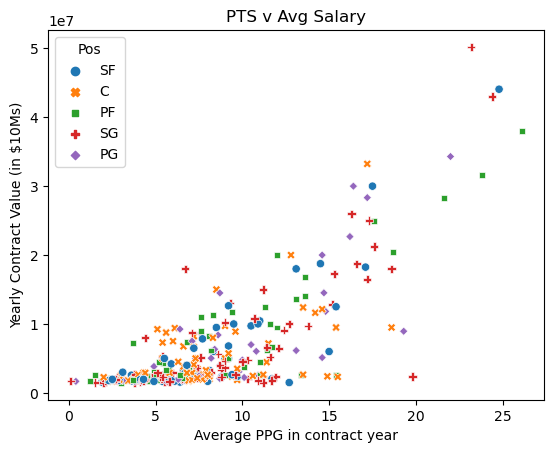

In [10]:
# PTS and salary has a very strong linear correlation
ax = sns.scatterplot(x='PTS',y='Avg_Salary', style = 'Pos', hue = "Pos", data = df_combined)
ax.set(title="PTS v Avg Salary", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

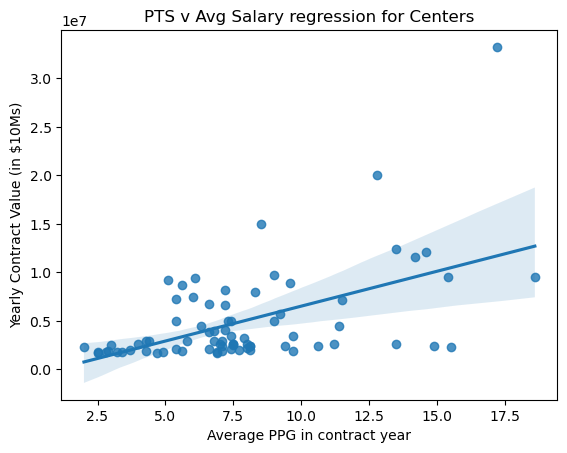

In [11]:
#It appears centers don't follow the linear pattern as closely as other positions
ax = sns.regplot(x='PTS',y='Avg_Salary', data = df_combined.loc[df_combined.Pos == 'C'])
ax.set(title="PTS v Avg Salary regression for Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'PTS v Avg Salary regression for non-Centers'),
 Text(0.5, 0, 'Average PPG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

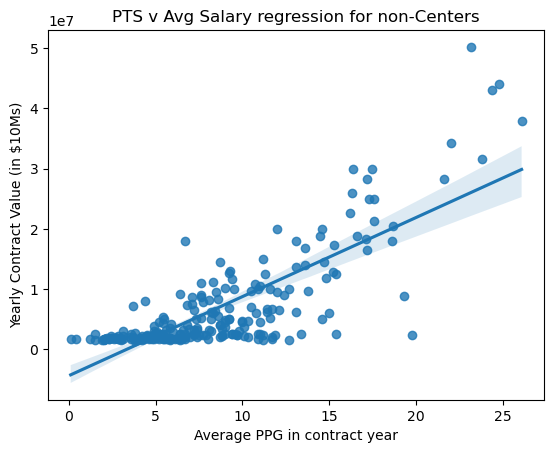

In [12]:
ax = sns.regplot(x='PTS',y='Avg_Salary', data = df_combined.loc[df_combined.Pos != 'C'])
ax.set(title="PTS v Avg Salary regression for non-Centers", xlabel="Average PPG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

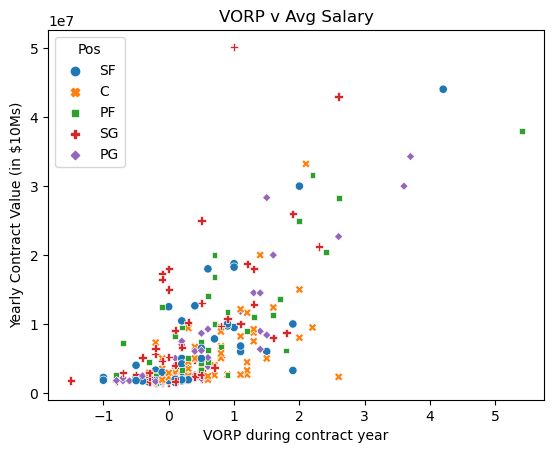

In [13]:
ax = sns.scatterplot(x='VORP',y='Avg_Salary', style = 'Pos', hue = "Pos", data = df_combined)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'VORP v Avg Salary'),
 Text(0.5, 0, 'VORP during contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

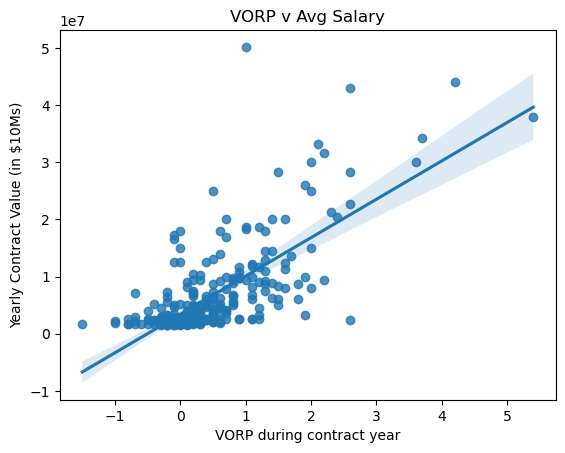

In [14]:
# VORP and salary has a strong linear correlation
ax = sns.regplot(x='VORP',y='Avg_Salary', data = df_combined)
ax.set(title="VORP v Avg Salary", xlabel="VORP during contract year", ylabel="Yearly Contract Value (in $10Ms)")

C:\Users\kthay\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Average Salary by position')

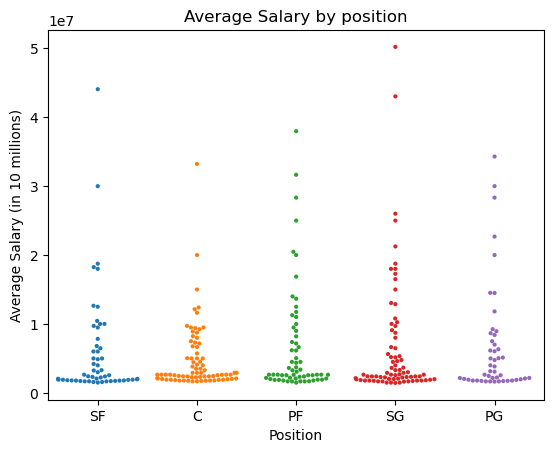

In [15]:
sns.swarmplot(x = 'Pos', y = 'Avg_Salary', s = 3, data = df_combined)
plt.xlabel("Position")
plt.ylabel("Average Salary (in 10 millions)")
plt.title('Average Salary by position')
# In recent years the highest paid players have been SGs and SFs, but overall no position is being paid significantly more

#### Since certain positions are generally paid to do specific things in basketball (as we've seen PTS isn't as strong of an indicator for centers), I tried splitting the df into wings/guards and bigs

In [16]:
wings_df = df_combined[(df_combined.Pos == "SF") | (df_combined.Pos == "SG") | (df_combined.Pos == "PG")]
len(wings_df)

176

In [17]:
#Rechecking correlation values for the split dfs
y = wings_df[['Avg_Salary']]
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.783
Pearsons correlation for TRB: 0.548
Pearsons correlation for AST: 0.619
Pearsons correlation for FGA: 0.738
Pearsons correlation for FG: 0.776
Pearsons correlation for FG.: 0.175
Pearsons correlation for X3P: 0.519
Pearsons correlation for X3PA: 0.525
Pearsons correlation for X2P.: 0.062
Pearsons correlation for STL: 0.406
Pearsons correlation for BLK: 0.229
Pearsons correlation for ORB: 0.196
Pearsons correlation for DRB: 0.584
Pearsons correlation for FT: 0.723
Pearsons correlation for FTA: 0.700
Pearsons correlation for G: 0.263
Pearsons correlation for GS: 0.590
Pearsons correlation for MP: 0.644


In [18]:
y = wings_df[['Avg_Salary']]
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(wings_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.738
Pearsons correlation for OWS: 0.690
Pearsons correlation for DWS: 0.467
Pearsons correlation for WS: 0.682
Pearsons correlation for WS.48: 0.347
Pearsons correlation for OBPM: 0.534
Pearsons correlation for DBPM: 0.062
Pearsons correlation for BPM: 0.470
Pearsons correlation for PER: 0.534
Pearsons correlation for TS.: 0.224
Pearsons correlation for eFG.: 0.142


In [19]:
bigs_df = df_combined[(df_combined.Pos == "C")  | (df_combined.Pos == "PF")]
bigs_df.head()
len(bigs_df)

137

In [20]:
y = bigs_df[['Avg_Salary']]
traditional_stats = ['PTS', 'TRB', 'AST','FGA','FG','FG.','X3P','X3PA','X2P.','STL','BLK','ORB','DRB','FT','FTA','G','GS','MP']
for x in traditional_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for PTS: 0.741
Pearsons correlation for TRB: 0.415
Pearsons correlation for AST: 0.513
Pearsons correlation for FGA: 0.682
Pearsons correlation for FG: 0.711
Pearsons correlation for FG.: 0.002
Pearsons correlation for X3P: 0.337
Pearsons correlation for X3PA: 0.328
Pearsons correlation for X2P.: -0.013
Pearsons correlation for STL: 0.430
Pearsons correlation for BLK: 0.270
Pearsons correlation for ORB: 0.235
Pearsons correlation for DRB: 0.468
Pearsons correlation for FT: 0.708
Pearsons correlation for FTA: 0.669
Pearsons correlation for G: 0.384
Pearsons correlation for GS: 0.590
Pearsons correlation for MP: 0.643


In [21]:
y = bigs_df[['Avg_Salary']]
advanced_stats = ['VORP','OWS','DWS','WS','WS.48','OBPM','DBPM','BPM','PER','TS.',"eFG."]
for x in advanced_stats:
    corr, _ = pearsonr(bigs_df[x],y)
    print('Pearsons correlation for %s: %.3f' %(x, corr))

Pearsons correlation for VORP: 0.741
Pearsons correlation for OWS: 0.687
Pearsons correlation for DWS: 0.547
Pearsons correlation for WS: 0.695
Pearsons correlation for WS.48: 0.238
Pearsons correlation for OBPM: 0.336
Pearsons correlation for DBPM: -0.012
Pearsons correlation for BPM: 0.274
Pearsons correlation for PER: 0.258
Pearsons correlation for TS.: 0.100
Pearsons correlation for eFG.: 0.022


AST, TRB, and DRB stand out as factors more correlated with wing pay than big pay
DWS stands out as more important for big than wing pay

[Text(0.5, 1.0, 'AST v Avg Salary regression for Wings'),
 Text(0.5, 0, 'Average APG in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

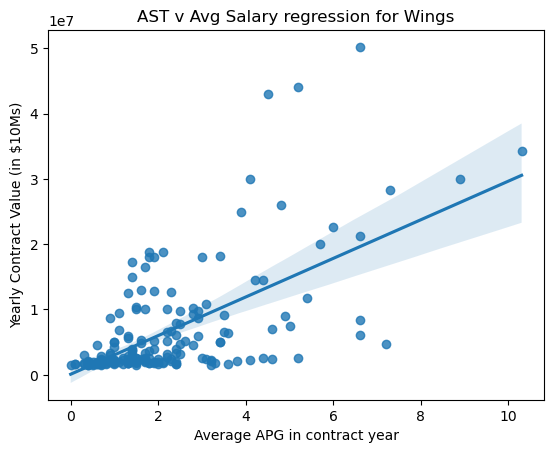

In [22]:
ax = sns.regplot(x='AST',y='Avg_Salary', data = wings_df)
ax.set(title="AST v Avg Salary regression for Wings", xlabel="Average APG in contract year", ylabel="Yearly Contract Value (in $10Ms)")

[Text(0.5, 1.0, 'DWS v Avg Salary regression for Bigs'),
 Text(0.5, 0, 'DWS in contract year'),
 Text(0, 0.5, 'Yearly Contract Value (in $10Ms)')]

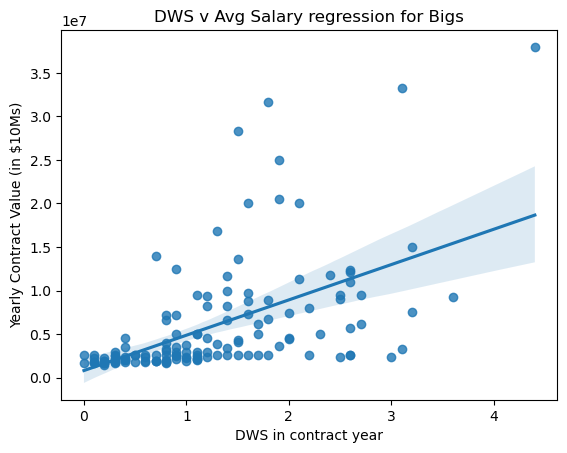

In [23]:
ax = sns.regplot(x='DWS',y='Avg_Salary', data = bigs_df)
ax.set(title="DWS v Avg Salary regression for Bigs", xlabel="DWS in contract year", ylabel="Yearly Contract Value (in $10Ms)")

## LINEAR REGRESSION MODELS ##

### ENTIRE DF ###

In [24]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 4021360.892491329


### Guards/Wings DF ###

In [25]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'DWS', 'AST']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 4064448.117902579


### Bigs DF ###

In [26]:
# use selected stats as predictor variable 
inputs = ['PTS','VORP','DRB', 'MP']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = LinearRegression()
model.fit(X_train,y_train)
# calculate R sq and adjusted R sq
#sal_rsq = model.score(X_test, y_test)
#print(f'R-squared: {sal_rsq}')
#sal_adjusted_rsq = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
#print(f'Adjusted: {sal_adjusted_rsq}')

# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3597437.7069298876


Overall, the linear regressions on the bigs dataframes performed better than the linear regression on the overall dataframe while the wings df performed similarly to the overall df. 

## DECISION TREE MODEL ##

In [27]:
# use selected stats as predictor variable 
inputs = ['PTS', 'Age', 'AST', 'MP']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

In [28]:
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)

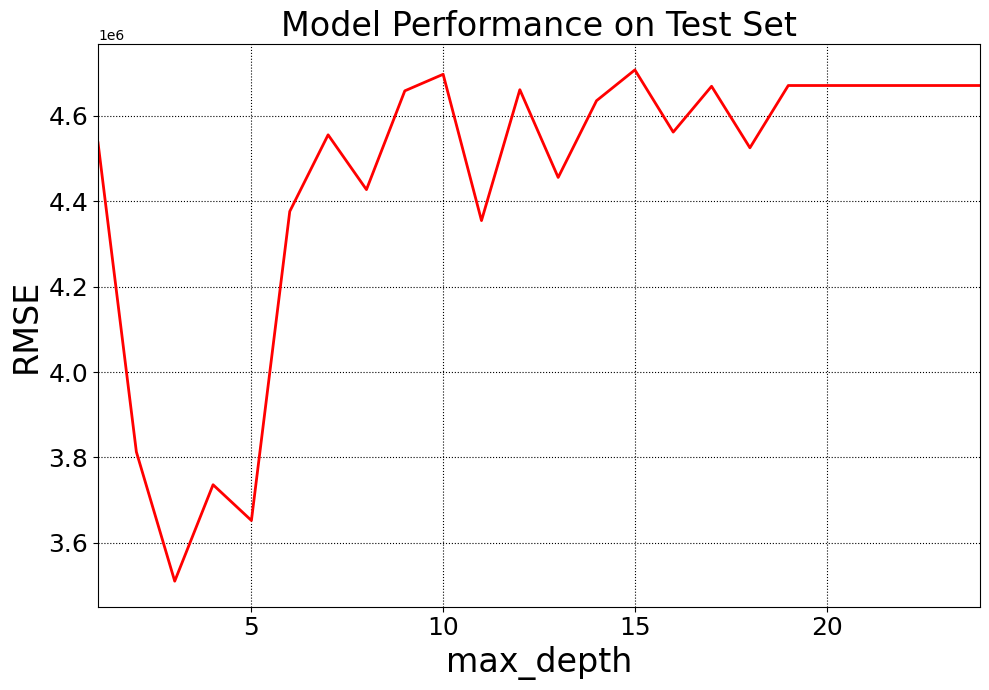

In [29]:
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [30]:
depth = 3
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3510012.892404469


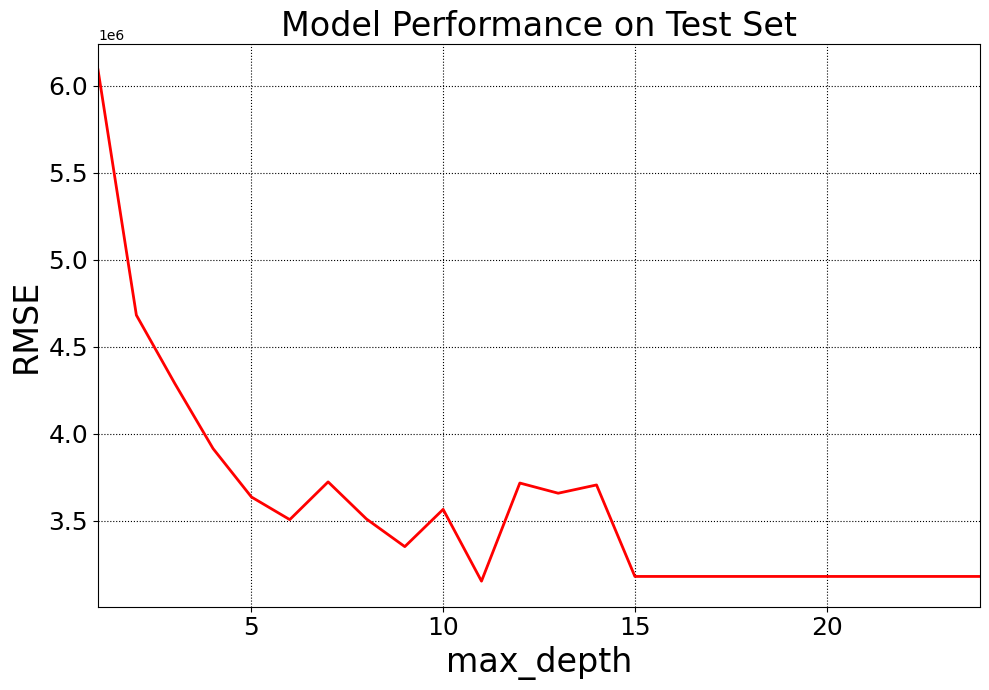

In [31]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'OWS', 'MP', 'AST']
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [32]:
depth = 15
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3181295.8844015053


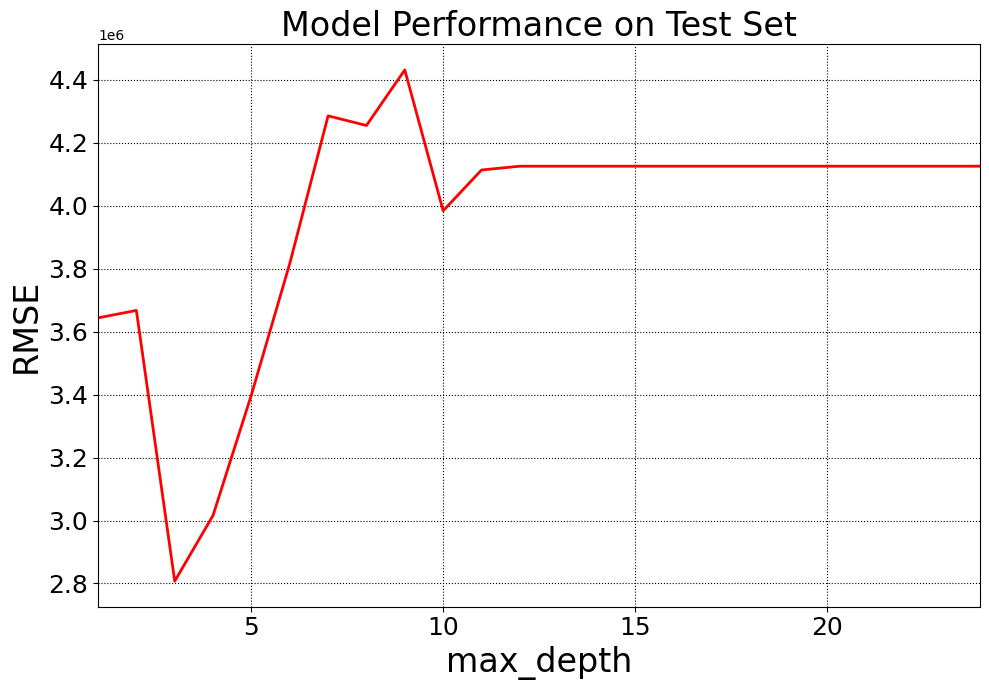

In [33]:
# use selected stats as predictor variable 
inputs = ['PTS', 'DWS']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
max_depth_range = list(range(1, 25))
# List to store the average RMSE for each value of max_depth:
rmse_list = []
for depth in max_depth_range:
    model = DecisionTreeRegressor(max_depth = depth,
                            random_state = 0)
    model.fit(X_train, y_train)   
    
    y_predicted = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_predicted, squared=False)
    rmse_list.append(rmse)
# graph of RMSE data
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                        figsize = (10,7),
                        facecolor = 'white');
ax.plot(max_depth_range,
        rmse_list,
        lw=2,
        color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
        axis = 'both',
        zorder = 0,
        linestyle = ':',
        color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('RMSE', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [34]:
depth = 3
model = DecisionTreeRegressor(max_depth = depth, random_state=0)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 2807303.708223315


The decision tree outperformed the linear regression on all 3 dfs, the positional dfs also outperformed the overall df

## XGBOOST MODEL ##

In [35]:
# use selected stats as predictor variable 
inputs = ['PTS','Age', 'PER', 'GS', 'AST']
X = df_combined[inputs]
# set y to avg_salary
y = df_combined[['Avg_Salary']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3206927.9554627873


In [36]:
# use selected stats as predictor variable 
inputs = ['PTS', 'VORP', 'AST', 'MP',]
X = wings_df[inputs]
# set y to avg_salary
y = wings_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 3073193.302567953


In [37]:
# use selected stats as predictor variable 
inputs = ['PTS','VORP','GS', 'TRB', 'DBPM']
X = bigs_df[inputs]
# set y to avg_salary
y = bigs_df[['Avg_Salary']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)
model = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 1)
model.fit(X_train,y_train)
# Predict RMSE
y_predicted = model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(f'RMSE: {rmse}')

RMSE: 2847377.6312780776


Overall, for looking at the entire DF, the xgboost model performed the best, but was similar to the decision tree model for the position based dataframes. The bigs models consistently outperformed the total models by a decent amount, and the guards/wings models slightly outperformed or about matched the entire DF models.
Soon I will be adding a feature allowing for the input of upcoming free agents, using the XGBoost and Decision Tree models to provide a predicted contract